# `AbsorptionModel` Tutorial

Trey V. Wenger (c) July 2025

Here we demonstrate the basic features of the `AbsorptionModel` model. `AbsorptionModel` models 21-cm Stokes I and V spectra toward a background continuum source. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [83]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_zeeman_hi
print("bayes_zeeman_hi version:", bayes_zeeman_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.23.0
arviz version: 0.22.0dev
bayes_spec version: 1.9.0
bayes_zeeman_hi version: 0+unknown


## Simulating Data

To test the model, we must simulate some data. We can do this with `AbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"I"` and `"V"`.

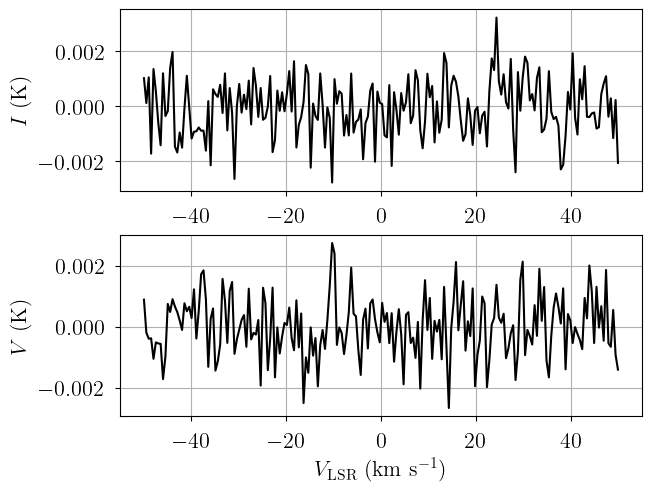

In [84]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = np.linspace(-50.0, 50.0, 200) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms = 0.001 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
stokesI = rms * np.random.randn(len(velo_axis))
stokesV = rms * np.random.randn(len(velo_axis))

dummy_data = {
    "I": SpecData(
        velo_axis,
        stokesI,
        rms,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$I$ (K)",
    ),
    "V": SpecData(
        velo_axis,
        stokesV,
        rms,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$V$ (K)",
    ),
}

# Plot dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["I"].spectral, dummy_data["I"].brightness, "k-")
axes[1].plot(dummy_data["V"].spectral, dummy_data["V"].brightness, "k-")
axes[1].set_xlabel(dummy_data["V"].xlabel)
axes[0].set_ylabel(dummy_data["I"].ylabel)
_ = axes[1].set_ylabel(dummy_data["V"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model. First we create the model.

In [85]:
from bayes_zeeman_hi import AbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
Tbg = 50.0 # K
model = AbsorptionModel(
    Tbg,
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total=10.0, # total optical depth prior width (km s-1)
    prior_fwhm2=200.0, # FWHM^2 prior width (km2 s-2)
    prior_velocity=[-20.0, 20.0],  # lower and upper limit of velocity prior (km/s)
    prior_Bparallel=[-20.0, 20.0], # lower and upper limit of Bparallel prior (uG)
    prior_leakage_fraction=0.01, # width of leakage fraction prior
)
model.add_likelihood()

Now we simulate with a given set of simulation parameters.

In [86]:
from bayes_zeeman_hi import physics

# Simulation parameters
tau_total = np.array([25.0, 15.0, 10.0])
fwhm = np.array([20.0, 15.0, 10.0])
velocity = np.array([-10.0, 0.0, 10.0])
Bparallel = np.array([-15.0, 5.0, 15.0])
leakage_fraction = 0.001

sim_params = {
    "tau_total": tau_total,
    "fwhm2": fwhm**2.0,
    "velocity": velocity,
    "Bparallel": Bparallel,
    "leakage_fraction": leakage_fraction,
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observation
stokesI = model.model["I"].eval(sim_params, on_unused_input="ignore")
stokesV = model.model["V"].eval(sim_params, on_unused_input="ignore")

# Add noise due to Stokes I
extra_rms = 0.00005 * stokesI
stokesI += extra_rms * np.random.randn(len(extra_rms))
stokesV += extra_rms * np.random.randn(len(extra_rms))
rms += extra_rms

data = {
    "I": SpecData(
        velo_axis,
        stokesI,
        rms,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$I$ (K)",
    ),
    "V": SpecData(
        velo_axis,
        stokesV,
        rms,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$V$ (K)",
    ),
}

In [87]:
sim_params

{'tau_total': array([25., 15., 10.]),
 'fwhm2': array([400., 225., 100.]),
 'velocity': array([-10.,   0.,  10.]),
 'Bparallel': array([-15.,   5.,  15.]),
 'leakage_fraction': 0.001}

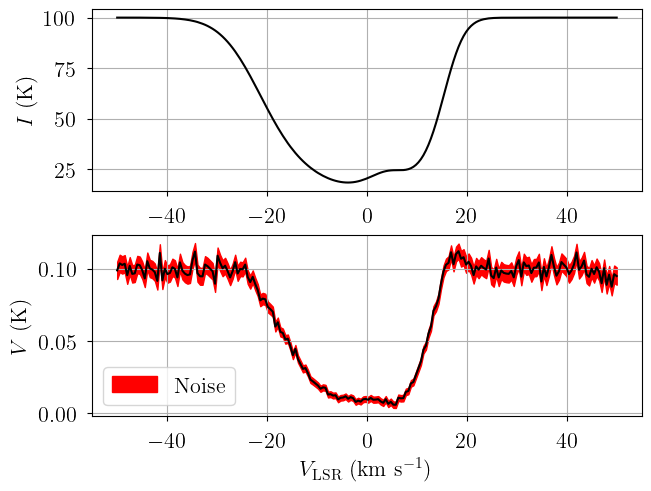

In [88]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(data["I"].spectral, data["I"].brightness, "k-")
axes[1].plot(data["V"].spectral, data["V"].brightness, "k-")
axes[1].fill_between(data["V"].spectral, data["V"].brightness-data["V"].noise, data["V"].brightness+data["V"].noise, color="r", label="Noise")
axes[1].set_xlabel(data["V"].xlabel)
axes[0].set_ylabel(data["I"].ylabel)
axes[1].legend(loc='best')
_ = axes[1].set_ylabel(data["V"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `AbsorptionModel`.

In [89]:
from bayes_zeeman_hi import AbsorptionModel

# Initialize and define the model
model = AbsorptionModel(
    Tbg,
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total=10.0, # total optical depth prior width (km s-1)
    prior_fwhm2=200.0, # FWHM^2 prior width (km2 s-2)
    prior_velocity=[-20.0, 20.0],  # lower and upper limit of velocity prior (km/s)
    prior_Bparallel=[-20.0, 20.0], # lower and upper limit of Bparallel prior (uG)
    prior_leakage_fraction=0.01, # width of leakage fraction prior
)
model.add_likelihood()

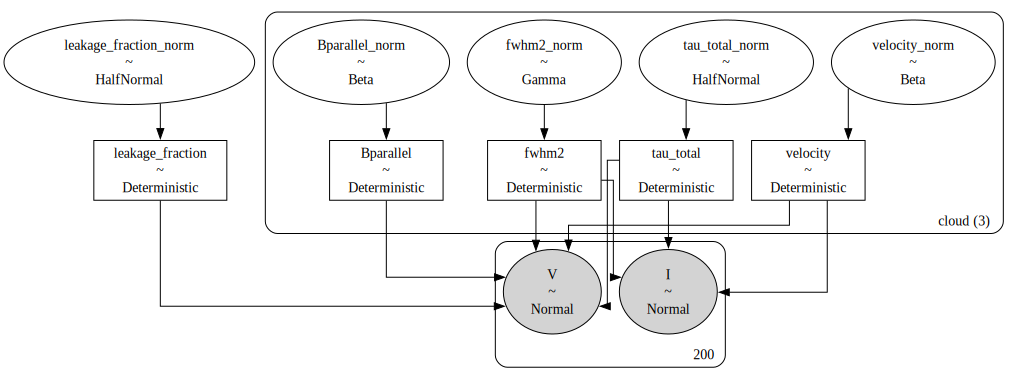

In [90]:
# Plot model graph
model.graph().render('absorption_model', format='png')
model.graph()

In [91]:
# model string representation
print(model.model.str_repr())

       tau_total_norm ~ HalfNormal(0, 1)
           fwhm2_norm ~ Gamma(0.5, f())
        velocity_norm ~ Beta(2, 2)
       Bparallel_norm ~ Beta(2, 2)
leakage_fraction_norm ~ HalfNormal(0, 1)
            tau_total ~ Deterministic(f(tau_total_norm))
                fwhm2 ~ Deterministic(f(fwhm2_norm))
             velocity ~ Deterministic(f(velocity_norm))
            Bparallel ~ Deterministic(f(Bparallel_norm))
     leakage_fraction ~ Deterministic(f(leakage_fraction_norm))
                    I ~ Normal(f(tau_total_norm, fwhm2_norm, velocity_norm), <constant>)
                    V ~ Normal(f(leakage_fraction_norm, tau_total_norm, fwhm2_norm, velocity_norm, Bparallel_norm), <constant>)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [Bparallel_norm, I, V, fwhm2_norm, leakage_fraction_norm, tau_total_norm, velocity_norm]


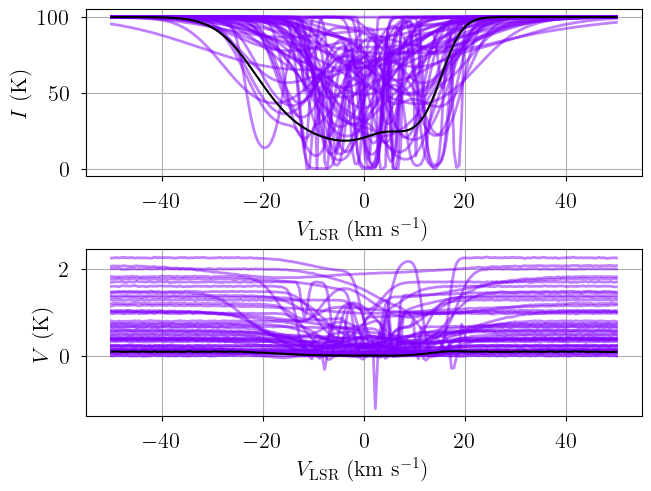

In [92]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=1000,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive.sel(draw=slice(None, None, 20)))

We can also check out our prior distributions impact the deterministic (derived) quantities in our model. The red points represent the simulation parameters.

In [93]:
print(model.cloud_freeRVs)
print(model.cloud_deterministics)

['tau_total_norm', 'fwhm2_norm', 'velocity_norm', 'Bparallel_norm']
['tau_total', 'fwhm2', 'velocity', 'Bparallel']


['tau_total', 'fwhm2', 'velocity', 'Bparallel']


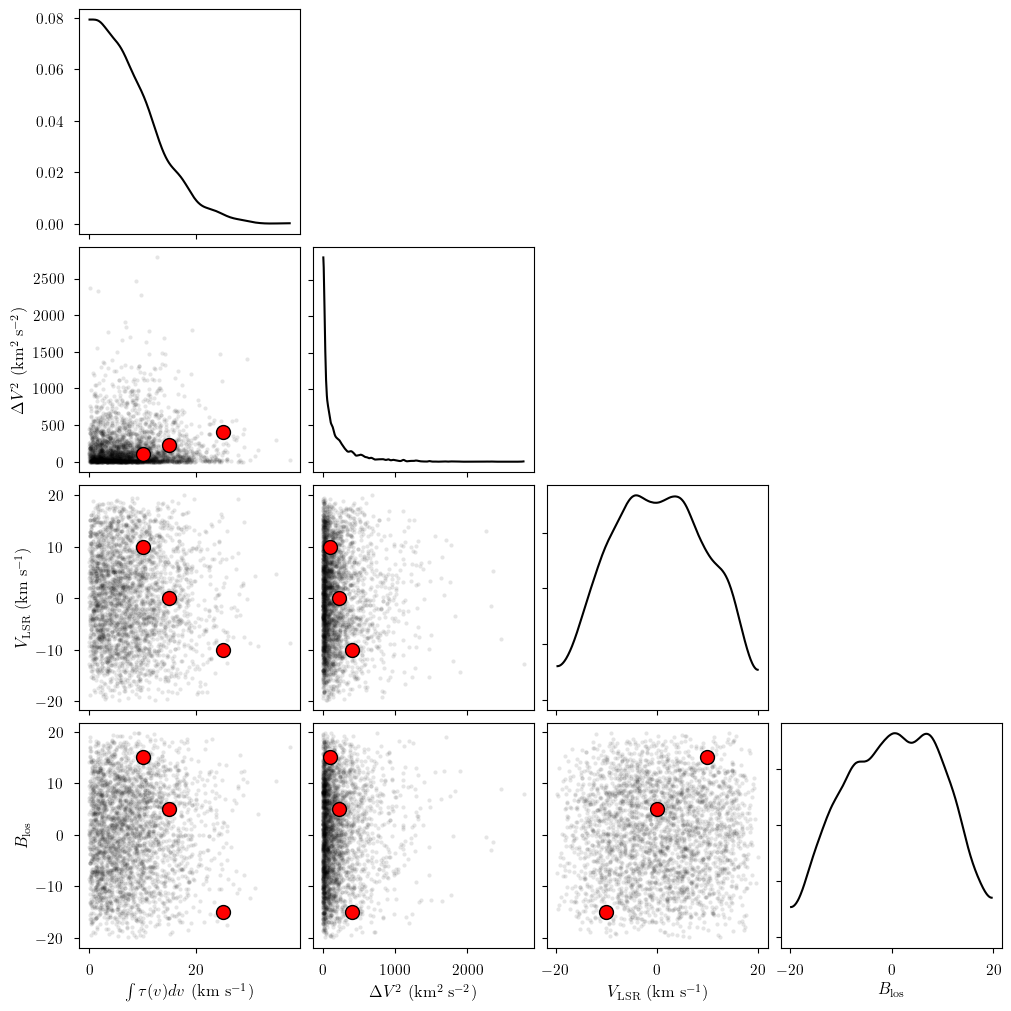

In [94]:
from bayes_spec.plots import plot_pair

var_names = model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
print(var_names)
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [95]:
start = time.time()
model.fit(
    n = 1_000_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.005, # VI relative convergence threshold
    abs_tolerance = 0.005, # VI absolute convergence threshold
    learning_rate = 0.001, # VI learning rate
    start = {"velocity_norm": np.linspace(0.25, 0.75, n_clouds)},
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 31100
Interrupted at 31,099 [3%]: Average Loss = 3.5978e+08


Adding log-likelihood to trace


Output()

Runtime: 0.31 minutes


In [96]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau_total_norm[0],2.176,0.001,2.175,2.178,0.000,0.000,948.0,962.0,NaN
tau_total_norm[1],1.897,0.001,1.896,1.899,0.000,0.000,862.0,908.0,NaN
tau_total_norm[2],0.926,0.000,0.925,0.926,0.000,0.000,1010.0,983.0,NaN
fwhm2_norm[0],1.873,0.001,1.871,1.876,0.000,0.000,895.0,866.0,NaN
fwhm2_norm[1],1.304,0.001,1.303,1.306,0.000,0.000,992.0,820.0,NaN
fwhm2_norm[2],0.485,0.000,0.484,0.485,0.000,0.000,994.0,934.0,NaN
velocity_norm[0],0.226,0.000,0.226,0.226,0.000,0.000,814.0,896.0,NaN
velocity_norm[1],0.494,0.000,0.494,0.494,0.000,0.000,1108.0,943.0,NaN
velocity_norm[2],0.752,0.000,0.752,0.752,0.000,0.000,1016.0,945.0,NaN
Bparallel_norm[0],0.077,0.014,0.054,0.103,0.000,0.000,978.0,942.0,NaN


Sampling: [I, V]


Output()

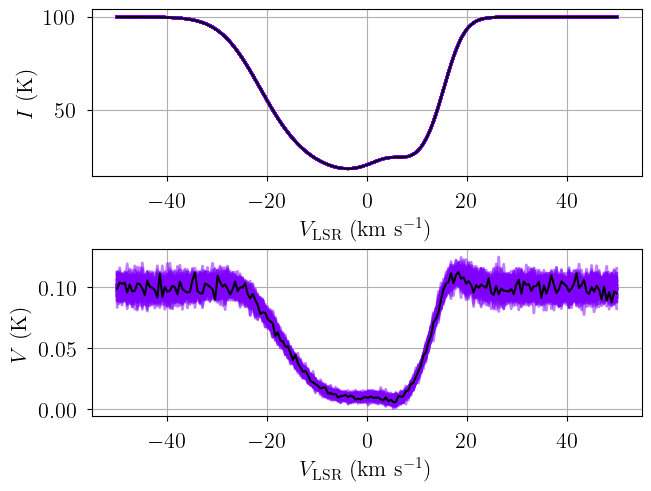

In [97]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [98]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=8,  # number of independent chains
    cores=8,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.005,
        "abs_tolerance": 0.005,
        "learning_rate": 0.001,
        "start": {"velocity_norm": np.linspace(0.25, 0.75, n_clouds)},
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 31100
Interrupted at 31,099 [3%]: Average Loss = 3.5978e+08
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_total_norm, fwhm2_norm, velocity_norm, Bparallel_norm, leakage_fraction_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 139 seconds.


Adding log-likelihood to trace


Output()

Runtime: 2.67 minutes


In [99]:
model.solve(
    init_params="random_from_data", # GMM initialization strategy
    n_init=10, # number of GMM initilizations
    max_iter=1_000, # maximum number of GMM iterations
    kl_div_threshold=0.1, # covergence threshold
)

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [100]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau_total_norm[0],2.502,0.003,2.498,2.508,0.000,0.000,1572.0,2344.0,1.0
tau_total_norm[1],1.497,0.003,1.491,1.503,0.000,0.000,1526.0,2279.0,1.0
tau_total_norm[2],1.000,0.001,0.999,1.002,0.000,0.000,1680.0,2572.0,1.0
fwhm2_norm[0],2.001,0.001,1.999,2.003,0.000,0.000,1659.0,2514.0,1.0
fwhm2_norm[1],1.124,0.001,1.121,1.126,0.000,0.000,1521.0,2335.0,1.0
fwhm2_norm[2],0.500,0.000,0.500,0.500,0.000,0.000,1898.0,3060.0,1.0
velocity_norm[0],0.250,0.000,0.250,0.251,0.000,0.000,1591.0,2344.0,1.0
velocity_norm[1],0.500,0.000,0.500,0.500,0.000,0.000,3426.0,4395.0,1.0
velocity_norm[2],0.750,0.000,0.750,0.750,0.000,0.000,1854.0,2919.0,1.0
Bparallel_norm[0],0.114,0.013,0.088,0.138,0.000,0.000,7441.0,5032.0,1.0


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [I, V]


Output()

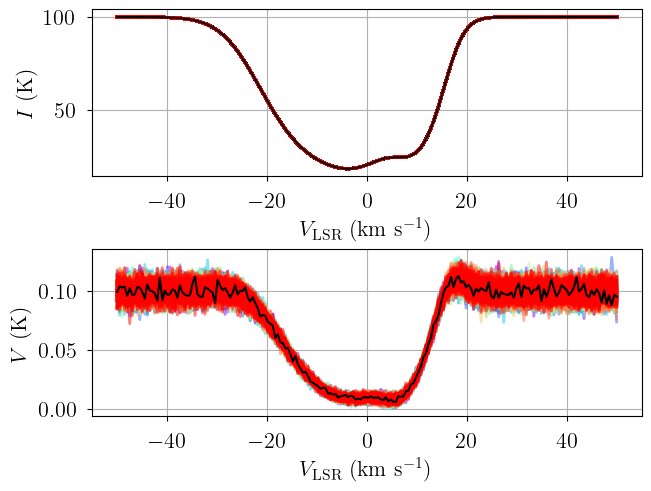

In [101]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

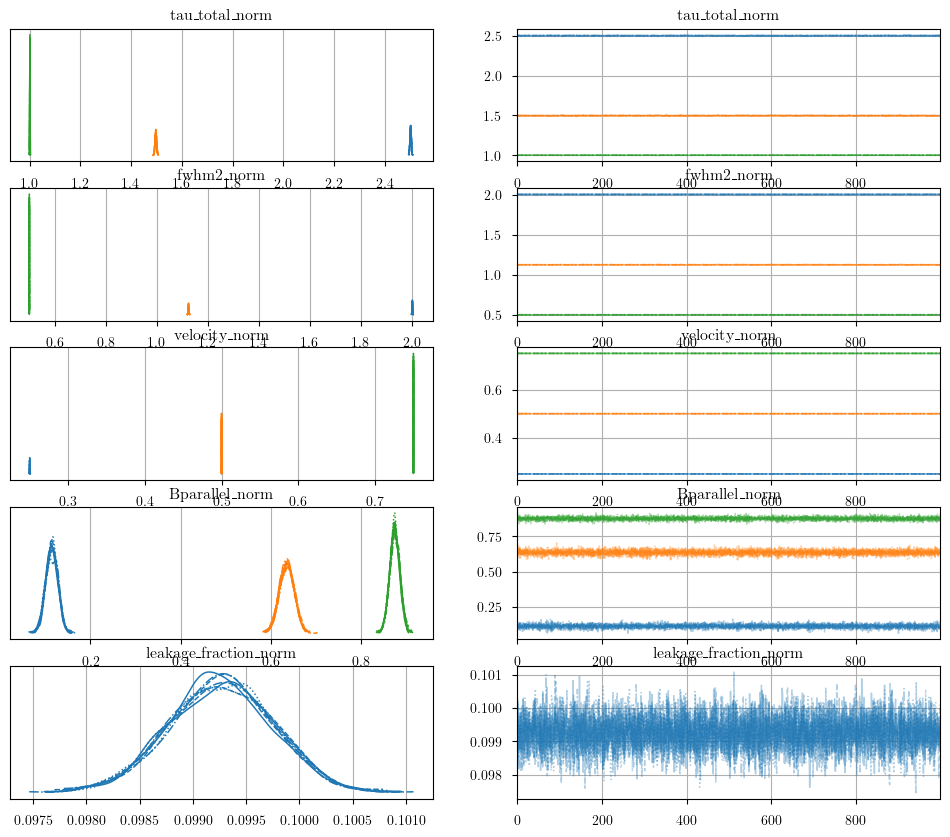

In [102]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the free parameters for all clouds. Keep an eye out for any strong degeneracies or non-linear correlations. If present, then these features can cause the posterior sampling to be inefficient. It may be worth re-parameterizing your model to remove these effects. Alternatively, increasing `tune` and `target_accept` can help.

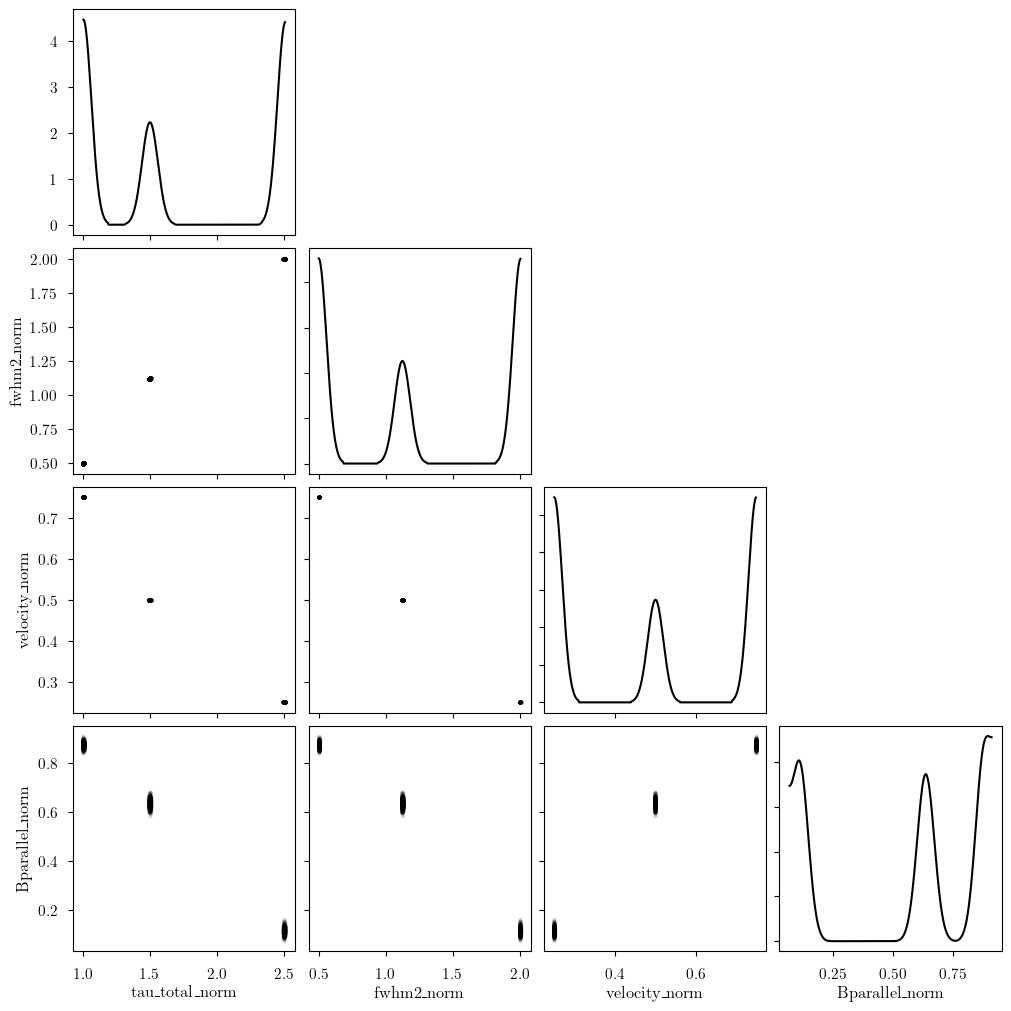

In [103]:
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    model.cloud_freeRVs, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    kind="scatter", # plot type
)

The red points represent the simulation parameters for the deterministic quantities.

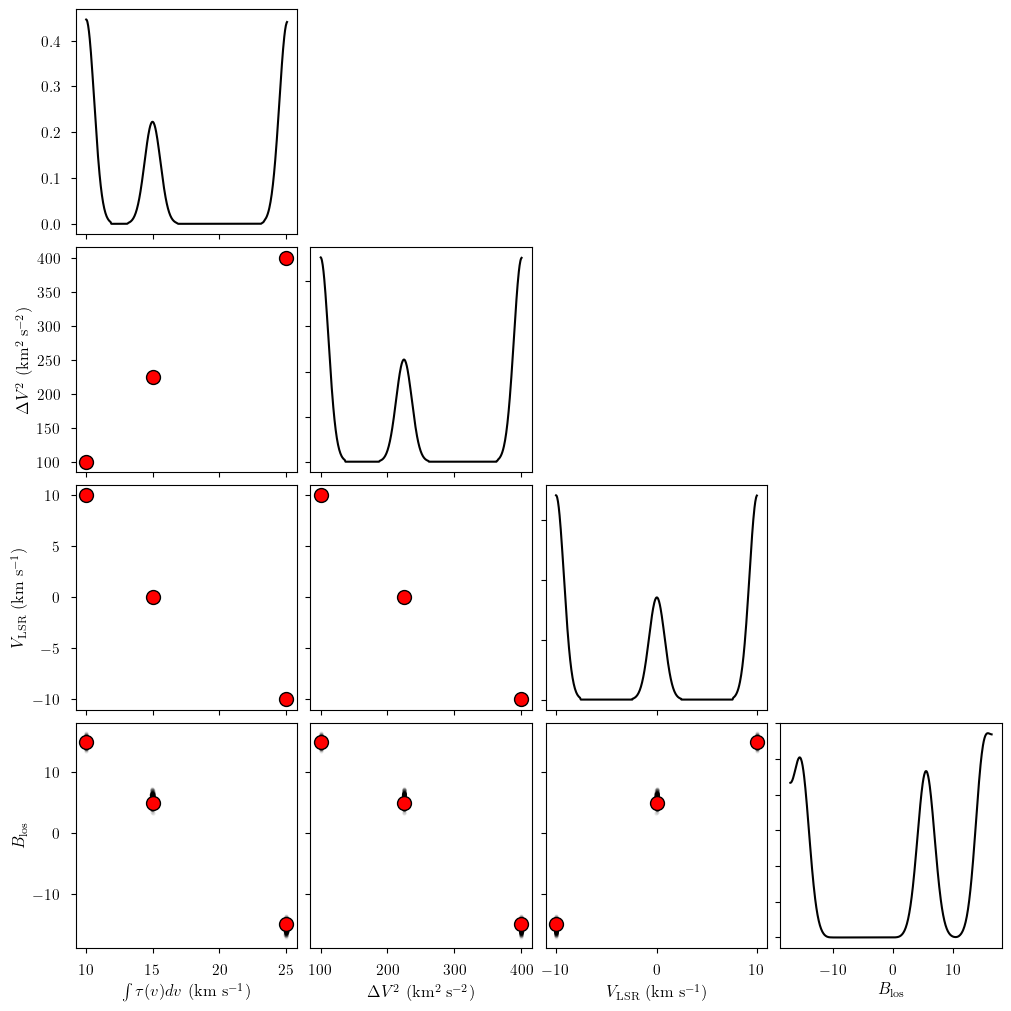

In [104]:
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

In [105]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}

In [106]:
print("cloud freeRVs", model.cloud_freeRVs)
print("cloud deterministics", model.cloud_deterministics)
print("hyper freeRVs", model.hyper_freeRVs)
print("hyper deterministics", model.hyper_deterministics)

cloud freeRVs ['tau_total_norm', 'fwhm2_norm', 'velocity_norm', 'Bparallel_norm']
cloud deterministics ['tau_total', 'fwhm2', 'velocity', 'Bparallel']
hyper freeRVs ['leakage_fraction_norm']
hyper deterministics ['leakage_fraction']


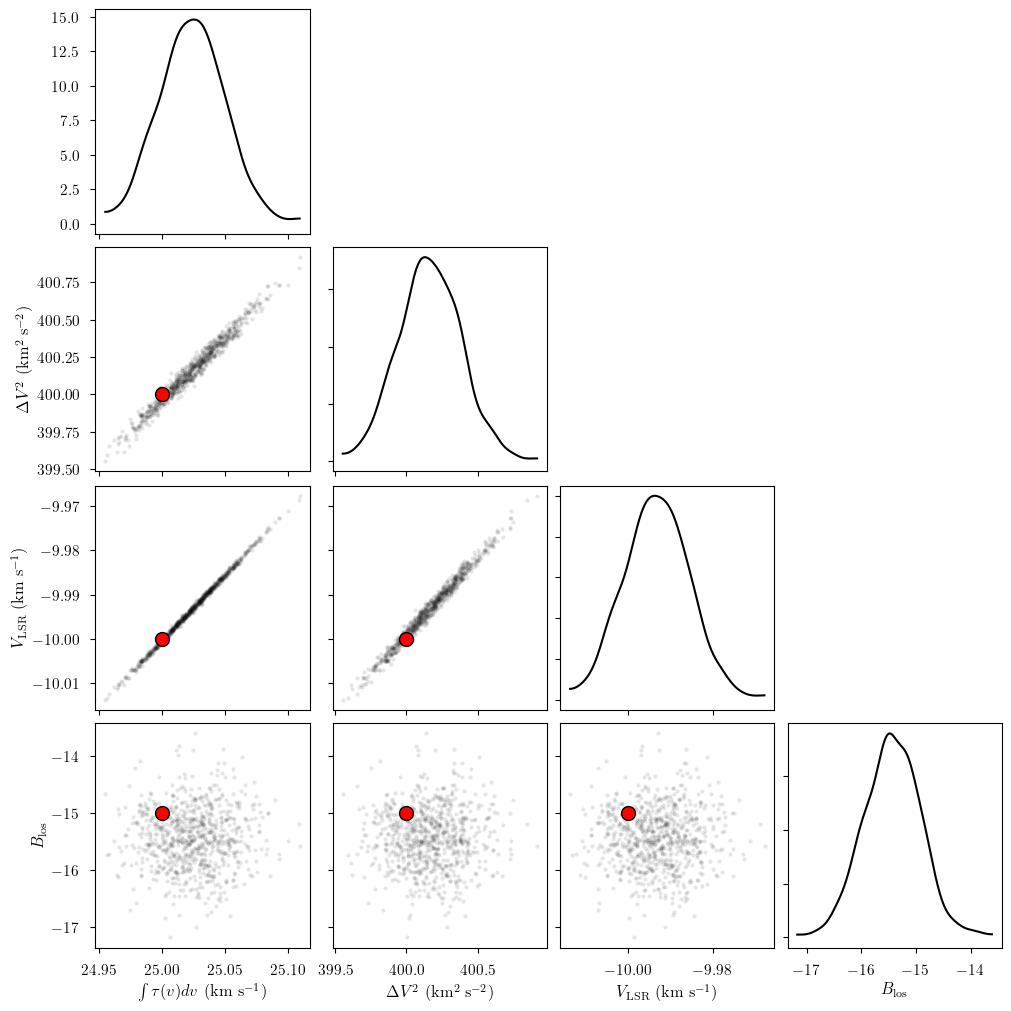

In [107]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

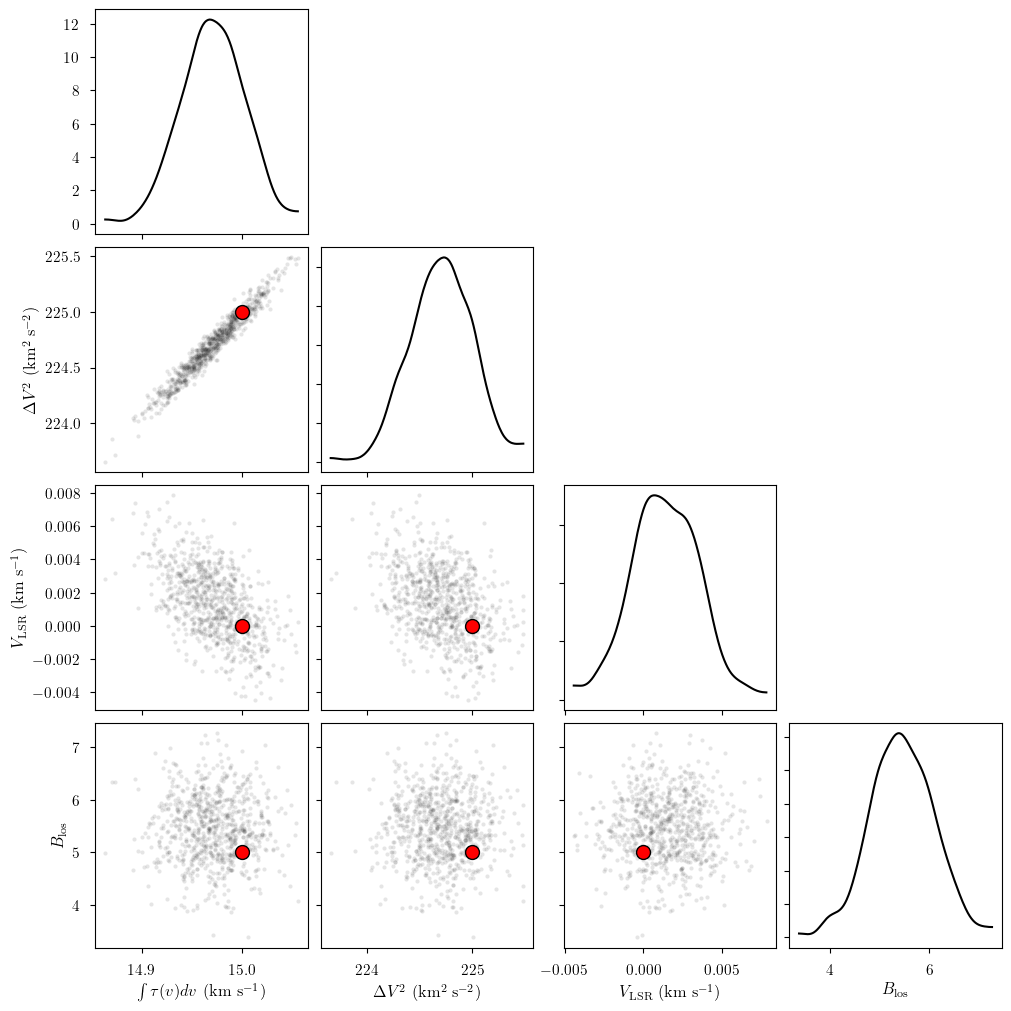

In [108]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

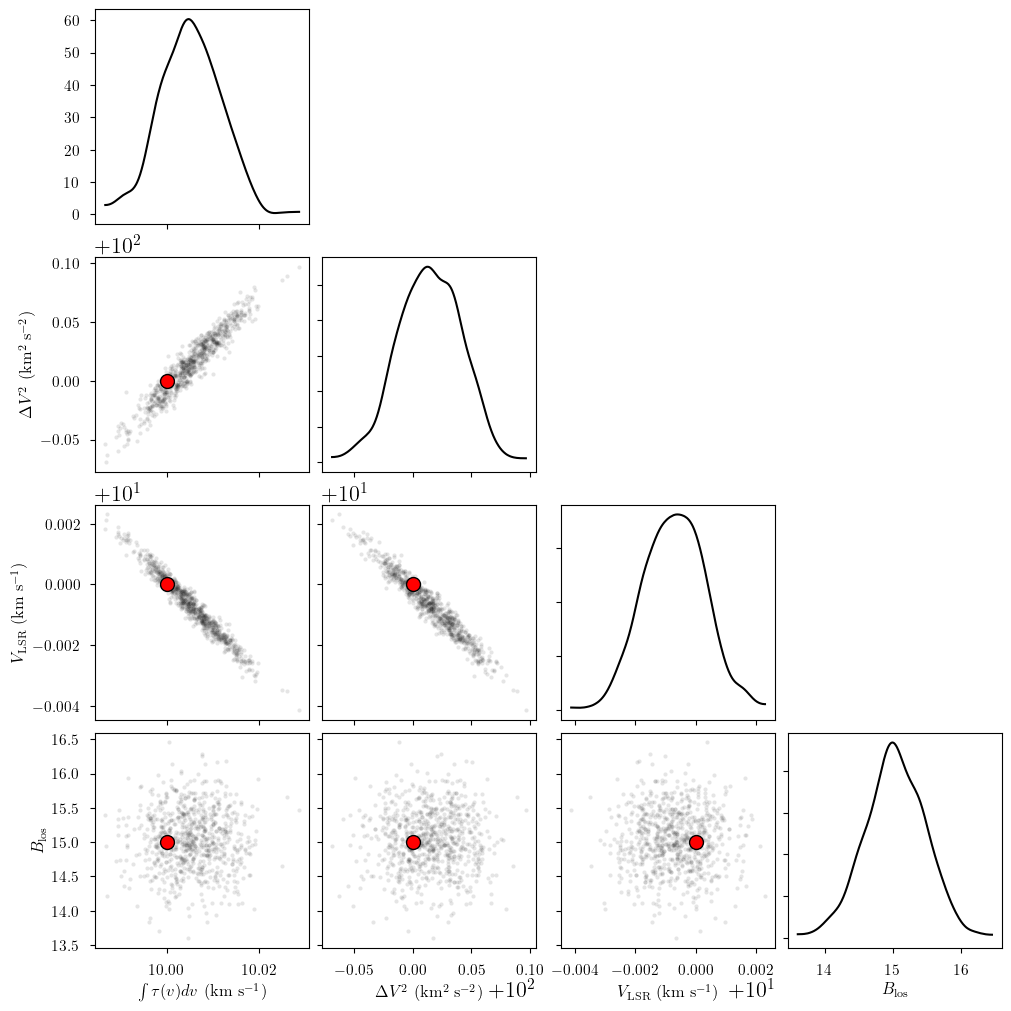

In [109]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [110]:
point_stats = az.summary(model.trace.solution_0, kind='stats')
print("BIC:", model.bic())
display(point_stats)

BIC: -3319.072458583611


,mean,sd,hdi_3%,hdi_97%
tau_total_norm[0],2.502,0.003,2.498,2.508
tau_total_norm[1],1.497,0.003,1.491,1.503
tau_total_norm[2],1.000,0.001,0.999,1.002
fwhm2_norm[0],2.001,0.001,1.999,2.003
fwhm2_norm[1],1.124,0.001,1.121,1.126
fwhm2_norm[2],0.500,0.000,0.500,0.500
velocity_norm[0],0.250,0.000,0.250,0.251
velocity_norm[1],0.500,0.000,0.500,0.500
velocity_norm[2],0.750,0.000,0.750,0.750
Bparallel_norm[0],0.114,0.013,0.088,0.138
